# T3SS measurments

This notebook is used to perform measurments of T3SS from three manually determined: 0 (inner membrane/basal body interface ), 1 (basal body/needle junction or basal body/bacteria outer membrane junction for the basal body only) and 2 (needle tip or vacuole membrane/T3SS tip interface, not always present).

The input to this notebook is an IMOD .mod file and the corresponding tomograms.

The output is a table containing the measurements.

## Description

Measurements in nm and degrees
- distance 1<->2
- distance 2<->3 (only if 3 exists within the same object)
- angle between 21 and 23
- distances between all 2

Perform measurements for
- each dataset
- each T3SS

Output is a table containing
- dataset
- T3SS id
- measurements


## Software environment
Use this notebook with a conda env:

- `conda create -n t3ss_geo python=3.10`
- `conda activate t3ss_geo`
- `pip install mrcfile pandas imodmodel ipython jupyter matplotlib seaborn ipympl scipy xarray`

In [1]:
import os, glob
import pandas as pd
import numpy as np
import imodmodel
import mrcfile
from scipy import spatial
import xarray as xr

In [2]:
base_dir = '/Volumes/Eirene/Points'

output_dir = os.path.join(base_dir, 'point_measurements')

ds_paths = [p for p in glob.glob(base_dir + '/*Points*/0*') if os.path.isdir(p)]
print(ds_paths)

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

['/Volumes/Eirene/Points/20240502_Points/060B37G4', '/Volumes/Eirene/Points/20240502_Points/060B36G3', '/Volumes/Eirene/Points/20240502_Points/053B41G2', '/Volumes/Eirene/Points/Points_corrected/057B30G2', '/Volumes/Eirene/Points/Points_corrected/054B36G1', '/Volumes/Eirene/Points/Points_corrected/053B40G2']


In [3]:
# Extract info from files

dfs = []

def extract_ts_id_from_fn(fn):
    return int(fn.split('_')[2])

log_msgs = []

for ds_path in ds_paths:
    ds_dir = os.path.basename(ds_path)
    fns = [fn for fn in os.listdir(ds_path) if fn.startswith(ds_dir) and fn.endswith('.mrc')]
    for fn in fns:

        if 'rec_corrected.mrc' not in fn:
            root_name = fn.split('.mrc')[0]
        else:
            root_name = fn.split('rec_corrected.mrc')[0]

        # find file that starts with root_name and ends with T3SS.mod
        t3ss_name = [fn for fn in os.listdir(ds_path)
        if fn.startswith(root_name) and fn.endswith('T3SS.mod')]
        if not len(t3ss_name): 
            msg = 'No T3SS model found for {}'.format(fn)
            log_msgs.append(msg)
            print(msg)
            continue
        else:
            t3ss_name = t3ss_name[0]

        t3ss_path = os.path.join(ds_path, t3ss_name)

        breaks_name = root_name + 'break.mod'
        breaks_path = os.path.join(ds_path, breaks_name)

        tdf = imodmodel.read(t3ss_path)
        tdf['source_fn'] = t3ss_name
        tdf['type'] = 'T3SS'

        cdf = tdf

        cdf['tomo_id'] = extract_ts_id_from_fn(fn)
        cdf['tomo_fn'] = fn
        cdf['ds'] = ds_dir

        cdf['contour_id'] = cdf['contour_id'].astype(int)
        cdf['object_id'] = cdf['object_id'].astype(int)

        # multiply with voxel size and convert to nm
        voxel_size = mrcfile.mmap(os.path.join(ds_path, fn), mode='r+').voxel_size.x
        for dim in ['x', 'y', 'z']:
            cdf[dim] = cdf[dim] * voxel_size / 10

        dfs.append(cdf)

df = pd.concat(dfs)
df
    

No T3SS model found for 057B30G2_TS_26_bin2_tiltcor_rec_corrected.mrc
No T3SS model found for 057B30G2_TS_05_bin2_tiltcor_rec_corrected.mrc
No T3SS model found for 057B30G2_TS_29_bin2_tiltcor_rec_corrected.mrc
No T3SS model found for 054B36G1_TS_05_bin2_tiltcor_rec_corrected.mrc
No T3SS model found for 054B36G1_TS_12_bin2_tiltcor_rec_corrected.mrc


object_id  contour_id            x           y           z  \
0           0           0  1081.923292  428.691392  249.464728   
0           0           1  1072.576086  400.035547  248.783097   
0           0           2  1060.745905  367.158035  247.829845   
0           1           0  1126.942120  416.072804  257.729156   
0           1           1  1117.331632  387.183329  256.087051   
..        ...         ...          ...         ...         ...   
0           3           1   370.818516  206.210713   61.402381   
0           3           2   324.699282  181.196337   68.270705   
0           0           0   678.462245  343.503309  100.492182   
0           0           1   665.284720  334.768706   86.524922   
0           0           2   614.406954  302.454664   87.218406   

                                            source_fn  type  tomo_id  \
0   060B37G4_TS_09_bin2_tiltcor_rec_corrected_T3SS...  T3SS        9   
0   060B37G4_TS_09_bin2_tiltcor_rec_corrected_T3SS...  T3SS        9   
0   060B37G4_TS_09_bin2_tiltcor_rec_corrected_T3SS...  T3SS        9   
0   060B37G4_TS_09_bin2_tiltcor_rec_corrected_T3SS...  T3SS        9   
0   060B37G4_TS_09_bin2_tiltcor_rec_corrected_T3SS...  T3SS        9   
..                                                ...   ...      ...   
0                053B40G2_TS_18_bin3_tiltcor_T3SS.mod  T3SS       18   
0                053B40G2_TS_18_bin3_tiltcor_T3SS.mod  T3SS       18   
0                053B40G2_TS_04_bin3_tiltcor_T3SS.mod  T3SS        4   
0                053B40G2_TS_04_bin3_tiltcor_T3SS.mod  T3SS        4   
0                053B40G2_TS_04_bin3_tiltcor_T3SS.mod  T3SS        4   

                                          tomo_fn        ds  
0   060B37G4_TS_09_bin2_tiltcor_rec_corrected.mrc  060B37G4  
0   060B37G4_TS_09_bin2_tiltcor_rec_corrected.mrc  060B37G4  
0   060B37G4_TS_09_bin2_tiltcor_rec_corrected.mrc  060B37G4  
0   060B37G4_TS_09_bin2_tiltcor_rec_corrected.mrc  060B37G4  
0   060B37G4_TS_09_bin2_tiltcor_rec_corrected.mrc  060B37G4  
..                                            ...       ...  
0   053B40G2_TS_18_bin3_tiltcor_rec_corrected.mrc  053B40G2  
0   053B40G2_TS_18_bin3_tiltcor_rec_corrected.mrc  053B40G2  
0   053B40G2_TS_04_bin3_tiltcor_rec_corrected.mrc  053B40G2  
0   053B40G2_TS_04_bin3_tiltcor_rec_corrected.mrc  053B40G2  
0   053B40G2_TS_04_bin3_tiltcor_rec_corrected.mrc  053B40G2  

[415 rows x 10 columns]

In [5]:
# Perform measurements

def measure(gdf):
    """
    Measure the distance between two contours
    """
    # get position of contours

    tdf = gdf[gdf.type=='T3SS']

    tdf = tdf.sort_values(by=['object_id', 'contour_id'])

    positions = []
    for contour_id in [0, 1, 2]:
        if contour_id not in tdf.contour_id.values:
            positions.append(np.array([np.nan, np.nan, np.nan]))
            continue
        x = tdf[tdf.contour_id==contour_id].x[0]
        y = tdf[tdf.contour_id==contour_id].y[0]
        z = tdf[tdf.contour_id==contour_id].z[0]
        positions.append(np.array([x, y, z]))

    # 1) distance 1<->2
    d12 = np.linalg.norm(positions[0] - positions[1])

    # 2) distance 2<->3 (only if 3 exists within the same object)
    d23 = np.linalg.norm(positions[1] - positions[2])

    # 3) angle between 21 and 23
    a = np.arccos(np.dot(positions[0] - positions[1], positions[2] - positions[1]) / (np.linalg.norm(positions[0] - positions[1]) * np.linalg.norm(positions[2] - positions[1])))
    a = np.degrees(a)

    ms = pd.DataFrame({
        'distance_1_2': [d12],
        'distance_2_3': [d23],
        'angle_21_23': [a],
        })

    return ms
    

mdf = df.groupby(['ds', 'tomo_id', 'object_id']).apply(measure)
mdf.to_csv(os.path.join(output_dir, 't3ss_geometry.csv'))
open(os.path.join(output_dir, 't3ss_geometry.log'), 'w').write('\n'.join(log_msgs))
mdf

/var/folders/fb/ccf_crrx195fclngv32r4xcc0000gq/T/ipykernel_61378/1535911639.py:42: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mdf = df.groupby(['ds', 'tomo_id', 'object_id']).apply(measure)


distance_1_2  distance_2_3  angle_21_23
ds       tomo_id object_id                                           
053B40G2 4       0         0     21.095611     60.276241   137.868919
         5       0         0     29.502676           NaN          NaN
                 1         0     24.832307     43.241020   164.050163
                 2         0     30.172572           NaN          NaN
                 3         0     31.087429     26.944366   164.258483
...                                    ...           ...          ...
060B37G4 9       2         0     33.202921     60.790878   166.524540
         10      0         0     29.508353     53.589667   173.707688
                 1         0     27.696412     46.607106   170.740293
                 2         0     30.226147     51.450784   179.969690
                 3         0     31.408964     58.208961   172.686151

[147 rows x 3 columns]

In [6]:
# 4) distances between 2

tdf = df[df.type=='T3SS']
for ds in np.unique(tdf.ds):
    stdf = tdf[tdf.ds==ds]
    for tomo_id in np.unique(stdf.tomo_id):
        tstdf = stdf[stdf.tomo_id==tomo_id]
        tstdf2 = tstdf[tstdf.contour_id==1]
        tstdf2 = tstdf2.sort_values(by=['object_id'])
        poss = np.array([tstdf2.x, tstdf2.y, tstdf2.z]).T
        d = spatial.distance_matrix(poss, poss)
        xd = xr.DataArray(d, dims=['object_id', 'object_id'], coords={'object_id': tstdf2.object_id})
        xd.to_pandas().to_csv(os.path.join(output_dir, f"t3ss_distances_ds_{tstdf2['ds'].values[0]}_tomo-id_{tstdf2['tomo_id'].values[0]}.csv"))

/Users/malbert/miniconda3/envs/t3ss_geo/lib/python3.10/site-packages/xarray/namedarray/core.py:264: UserWarning: Duplicate dimension names present: dimensions {'object_id'} appear more than once in dims=('object_id', 'object_id'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  self._dims = self._parse_dimensions(dims)


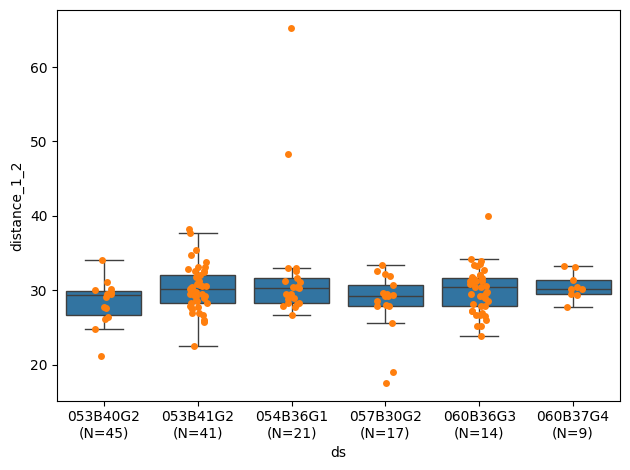

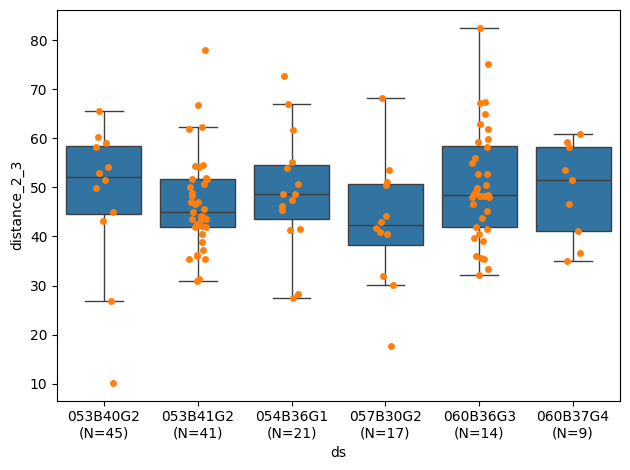

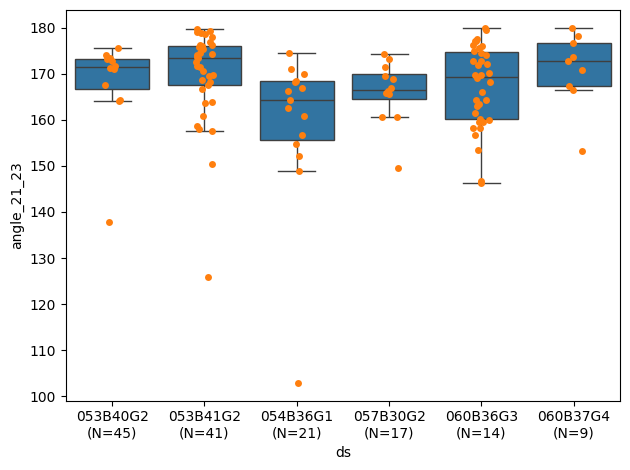

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

pmdf = mdf.reset_index()

xcol = 'ds'
for ycol in ['distance_1_2', 'distance_2_3', 'angle_21_23']:
    plt.figure()
    ax = sns.boxplot(data=pmdf, x='ds', y=ycol, fliersize=0)
    ax2 = sns.stripplot(data=pmdf, x='ds', y=ycol, size=5)

    nobs = pmdf[xcol].value_counts().values

    pos = range(len(nobs))
    labels = [ax.get_xticklabels()[i].get_text() for i in pos]
    labels = [l + '\n(N=%s)'%nobs[i] for i, l in enumerate(labels)]
    ax.set_xticks(pos)
    ax.set_xticklabels(labels)

    plt.tight_layout()

    plt.savefig(os.path.join(output_dir, 't3ss_geometry_{}.pdf'.format(ycol)), dpi=300)
